In [263]:
import requests #This allows you to get the HTML code
from pattern import web #This allows you to explore the dom (i.e. the HTML structure)
from BeautifulSoup import BeautifulSoup #This is an alternaticeve way of exploring the dom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
url = "http://www.imdb.com/search/title" #This is the URL whose HTML we want to scrape

totnumfilms = 10000
page_starts = range(1,totnumfilms,100) # Since each page can only load 100 films, will need to load
                                       # up a whole bunch of pages.
moviefile = open("top10000movies.txt", 'w')

for startlocation in page_starts:
    additional_requirements = {"at":0, "sort":"num_votes,desc", "start":startlocation, "year":"1990,2015", "count": totnumfilms} 
    #if the URL has parameters you can give it, we can do so with the dictionary.
    #After studying the website, I see that this is the correct format: I want 
    #to sort my list by IMDB rating, in descending order, and am only interested
    #in the first page
    r = requests.get(url, params=additional_requirements)
    print r.url
    #If we instead print r.text we get the whole HTML

    #Now we're going to use pattern to explore the dom
    dom = web.Element(r.text) #This creates the dom in such a way that
                              #I can search for specific "tags", like <a href...>blabla</a>
                              #so as to fish out the information in that tag

    #Now we're going to create a file where we plug in all the information

    for movie in dom.by_tag("td.title"):
        #print movie
        #we want the title. It's found in the first entry(i.e. [0]) of the possible <a> tags
        #If we want the text between the tags, we ask for the .content
        if len(movie.by_tag("span.year_type")[0].content) <= 6:
            #some are not films but rather TV series or video games:
            #they all have a very long year tag that explains, so we can easily filter them out.
            idmovie = movie.by_tag("div.rating rating-list")[0].attrs["id"].split("|")[0]
            movtit = movie.by_tag("a")[0].content 
            year = movie.by_tag("span.year_type")[0].content[1:5]
            score = movie.by_tag("span.value")[0].content
            votes = movie.by_tag("div.rating rating-list")[0].attrs["title"].split()[4][1:]
            #Now remove the spurious commas
            templist = [ii for ii in reversed([int(ga) for ga in votes.split(",")])]
            votes = "%d" % sum([pow(1000,ii)*templist[ii] for ii in range(len(templist))])
            try:
                runtime = (movie.by_tag("span.runtime")[0].content).split()[0]
            except IndexError:
                runtime = "100"
            genre = "".join([gen.content+"," for gen in movie.by_tag("span.genre")[0].by_tag("a")])[0:-1]
    
            moviefile.write(idmovie)
            moviefile.write("\t")
            moviefile.write(movtit)
            moviefile.write("\t")
            moviefile.write(year)
            moviefile.write("\t")
            moviefile.write(score)
            moviefile.write("\t")
            moviefile.write(votes)
            moviefile.write("\t")
            moviefile.write(runtime)
            moviefile.write("\t")
            moviefile.write(genre)
            moviefile.write("\n")
            #print idmovie + "\t" + movtit + "\t" + year + "\t" + score + "\t" + votes + "\t" + runtime + "\t" + genre
            #print "----------------"
    
moviefile.close()

http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=1&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=101&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=201&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=301&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=401&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=501&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=601&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=701&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=801&year=1990%2C2015&count=10000&at=0
http://www.imdb.com/search/title?sort=num_votes%2Cdesc&start=901&year=1990%2C2015&count=10000&at=0
http://www.i

In [35]:
#Now let's make the table!
categories = ["imdbID","Title","Year","Score","Votes","Runtime","Genre"]
data = pd.read_csv("top10000movies.txt", delimiter="\t", names=categories)
print "Number of rows: %i" % data.shape[0]

#Now let's break up all the genres into separate columns. First find our what all the genres are.
allgenres = set() #creates an empty list with curly brackets: this is a set
for film in data.Genre:
    allgenres.update(film.split(",")) #gives lists to put into the set, and increase the set if necessary
    
allgenres = sorted(allgenres) #turns the curly brakcets into square brackets
#We have an alphabetical list with all the genres!

Number of rows: 7622


In [36]:
for gen in allgenres:
    #for each film in the list of genres of various films, check if the genre 
    #we're itnerested in right now (called gen) is in this list. I.e. check 
    #whether gen is in the first film, then check if it's in the second film, 
    #etc. Each iteration will be a list of elements of length "number of films",
    #each element telling you whether gen is in that list or not.
    newcolumn = [(gen in film.split(",")) for film in data.Genre]
    #to create a new column in our dataframe it's really easy:
    data[gen] = newcolumn

data.head()


,imdbID,Title,Year,Score,Votes,Runtime,Genre,Action,Adventure,Animation,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,tt0111161,The Shawshank Redemption,1994,9.3,1461805,142,"Crime,Drama",False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0468569,The Dark Knight,2008,9.0,1433976,152,"Action,Crime,Drama",True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt1375666,Inception,2010,8.8,1233451,148,"Action,Mystery,Sci-Fi,Thriller",True,False,False,...,False,False,False,True,False,True,False,True,False,False
3,tt0137523,Fight Club,1999,8.9,1144128,139,Drama,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,tt0110912,Pulp Fiction,1994,8.9,1136186,154,"Crime,Drama",False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
data[(data.Score<4) & (data.Year>2010)] #nice way of selecting the relevant data!

,imdbID,Title,Year,Score,Votes,Runtime,Genre,Action,Adventure,Animation,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
1770,tt0810913,Jack and Jill,2011,3.4,53166,91,Comedy,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1796,tt2574698,Gunday,2014,1.9,52284,152,"Action,Crime,Drama,Romance,Thriller",True,False,False,...,False,False,False,False,True,False,False,True,False,False
2025,tt0795461,Scary Movie 5,2013,3.5,43931,86,Comedy,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2625,tt1714203,Piranha 3DD,2012,3.8,29138,83,"Comedy,Horror",False,False,False,...,True,False,False,False,False,False,False,False,False,False
3048,tt1530509,The Human Centipede II (Full Sequence),2011,3.9,22684,91,Horror,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3388,tt2467046,Left Behind,2014,3.1,18218,110,"Action,Sci-Fi,Thriller",True,False,False,...,False,False,False,False,False,True,False,True,False,False
3644,tt4458206,Kod Adi K.O.Z.,2015,1.6,15958,114,"Crime,Mystery",False,False,False,...,False,False,False,True,False,False,False,False,False,False
3945,tt1517489,Spy Kids: All the Time in the World in 4D,2011,3.6,13611,89,"Action,Adventure,Comedy,Family,Sci-Fi",True,True,False,...,False,False,False,False,False,True,False,False,False,False
4118,tt2034139,The Last Exorcism Part II,2013,3.9,12308,88,"Drama,Horror,Thriller",False,False,False,...,True,False,False,False,False,False,False,True,False,False
4138,tt2403029,The Starving Games,2013,3.3,12150,83,Comedy,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
data.Runtime.describe() #A nice generic function that tells you useful stuff about this parameter

count    7622.000000
mean      107.406193
std        20.706909
min        46.000000
25%        94.000000
50%       103.000000
75%       116.000000
max       450.000000
Name: Runtime, dtype: float64

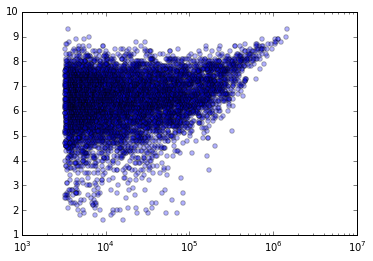

,imdbID,Title,Year,Score,Votes,Runtime,Genre,Action,Adventure,Animation,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
534,tt0118688,Batman &#x26; Robin,1997,3.6,171502,125,Action,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1163,tt0799949,Epic Movie,2007,2.3,83716,86,"Adventure,Comedy",False,True,False,...,False,False,False,False,False,False,False,False,False,False
1167,tt1073498,Meet the Spartans,2008,2.7,83011,86,Comedy,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1228,tt0327554,Catwoman,2004,3.3,79593,104,"Action,Crime",True,False,False,...,False,False,False,False,False,False,False,False,False,False
1399,tt1213644,Disaster Movie,2008,1.9,70085,87,Comedy,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1551,tt0185183,Battlefield Earth,2000,2.4,61706,118,"Action,Adventure,Sci-Fi",True,True,False,...,False,False,False,False,False,True,False,False,False,False
1695,tt0120179,Speed 2: Cruise Control,1997,3.7,55966,121,"Action,Crime,Romance,Thriller",True,False,False,...,False,False,False,False,True,False,False,True,False,False
1770,tt0810913,Jack and Jill,2011,3.4,53166,91,Comedy,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1796,tt2574698,Gunday,2014,1.9,52284,152,"Action,Crime,Drama,Romance,Thriller",True,False,False,...,False,False,False,False,True,False,False,True,False,False
1835,tt1098327,Dragonball: Evolution,2009,2.8,50599,85,"Action,Adventure,Fantasy,Sci-Fi,Thriller",True,True,False,...,False,False,False,False,False,True,False,True,False,False


In [271]:
plt.scatter(data.Votes, data.Score, alpha=.3)
plt.xscale("log")
plt.show()
data[(data.Votes>50000) & (data.Score<4)]

This is how many films there are of each type:

4345 Drama
3049 Comedy
2334 Thriller
1803 Romance
1612 Action
1484 Crime
971 Adventure
871 Horror
791 Mystery
704 Sci-Fi
666 Fantasy
585 Family
363 Biography
327 Animation
281 War
263 Music
254 History
239 Sport
143 Musical
82 Western

Year
1990    6.449655
1991    6.475839
1992    6.552288
1993    6.498305
1994    6.334171
1995    6.559804
1996    6.273636
1997    6.479911
1998    6.512931
1999    6.545714
2000    6.418702
2001    6.487368
2002    6.423127
2003    6.424415
2004    6.515057
2005    6.363085
2006    6.378873
2007    6.449412
2008    6.376471
2009    6.359005
2010    6.374757
2011    6.323294
2012    6.319664
2013    6.425995
2014    6.356011
2015    6.513115
Name: Score, dtype: float64

These are the most highly rated films of each year:
1990 Goodfellas
1991 The Silence of the Lambs
1992 We Are Not Angels
1993 Schindler&#x27;s List
1994 The Shawshank Redemption
1995 Se7en
1996 Pretty Village, Pretty Flame
1997 Life Is Beau

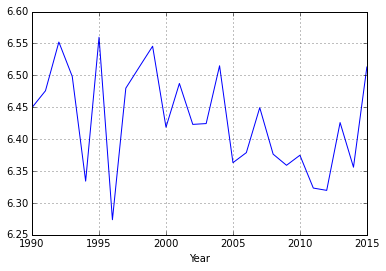

In [281]:
ordering = np.argsort((np.array(data[allgenres].sum())))[::-1]
print "This is how many films there are of each type:\n"
for ii in ordering:
    print (data[allgenres].sum())[ii], allgenres[ii]
#Now let's look at group properties
print "\n", data.groupby("Year").Score.mean()
data.groupby("Year").Score.mean().plot()

#When you look at group properties, you get a tuple of the property, and the dataframe that goes with it
print"\nThese are the most highly rated films of each year:"
for year, dataframe in data.groupby("Year"):
    print year, dataframe[dataframe.Score==dataframe.Score.max()].Title.values[0]

#Use this to get the average score for each category
print "\nAverage scores of each genre:"
genrescores = [round(data.groupby(genn).Score.describe()[1][1],2) for genn in allgenres]
ordering = np.argsort(genrescores)
genrescores = [genrescores[ii] for ii in ordering][::-1]
orderedgenre = [allgenres[ii] for ii in ordering][::-1]
for ii in range(len(allgenres)):
    print genrescores[ii], "\t", orderedgenre[ii]

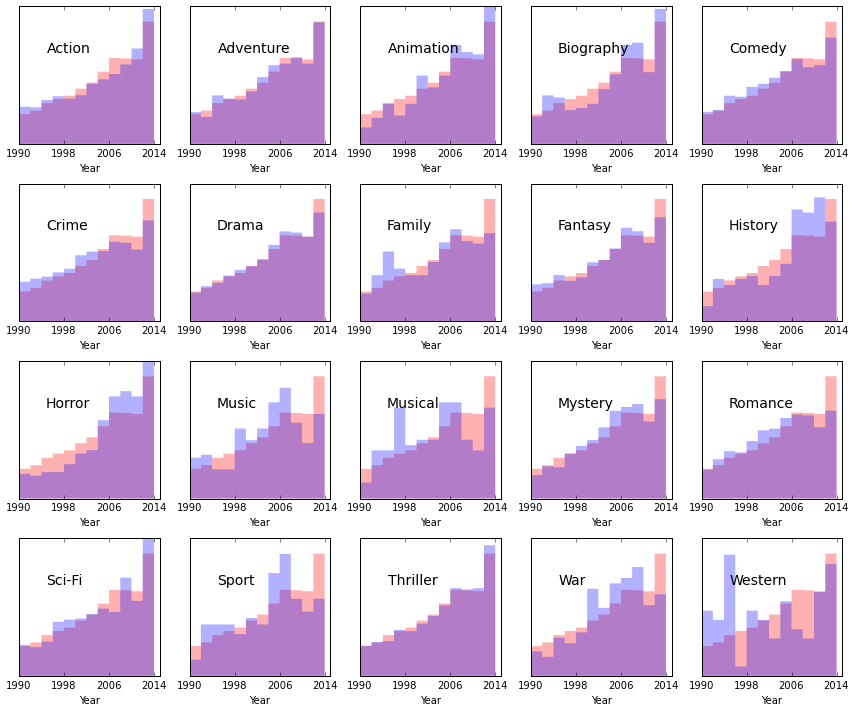

In [350]:
#We'll now make histograms that count the number of films of various types for various years
#Start by making a bunch of subplots (one for each genre)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12,10), tight_layout=True)
#Now we've made a figure with a bunch of elements (axes) in it.

bins = np.arange(1990,2015,2) #set the binsize to 2, and get all the corresponding bins.

# zip(list1,list2) creates a list of tuples tuple with [(list1[0],list2[0]), ... ]
# The function "ravel" is like Mathematica's "Flatten"
for ax, genre in zip(axes.ravel(), allgenres):
    # In each plot site "ax", make a histogram where we add to bins if a given film is in the genre "genre"
    ax.hist(data[data[genre]==1].Year.values, bins=bins, histtype="stepfilled", normed=True, color="b", alpha=0.3,ec="none")
    # In each plot site "ax", also make a histogram with ALL films
    ax.hist(data.Year.values, bins=bins, histtype="stepfilled", normed=True, ec="none", zorder=0, color="r", alpha=0.3)
    
    ax.annotate(genre, xy=(1995, 6e-2), fontsize=14)
    ax.xaxis.set_ticks(np.arange(1990,2015,8))
    ax.set_yticks([])
    ax.set_xlabel("Year")

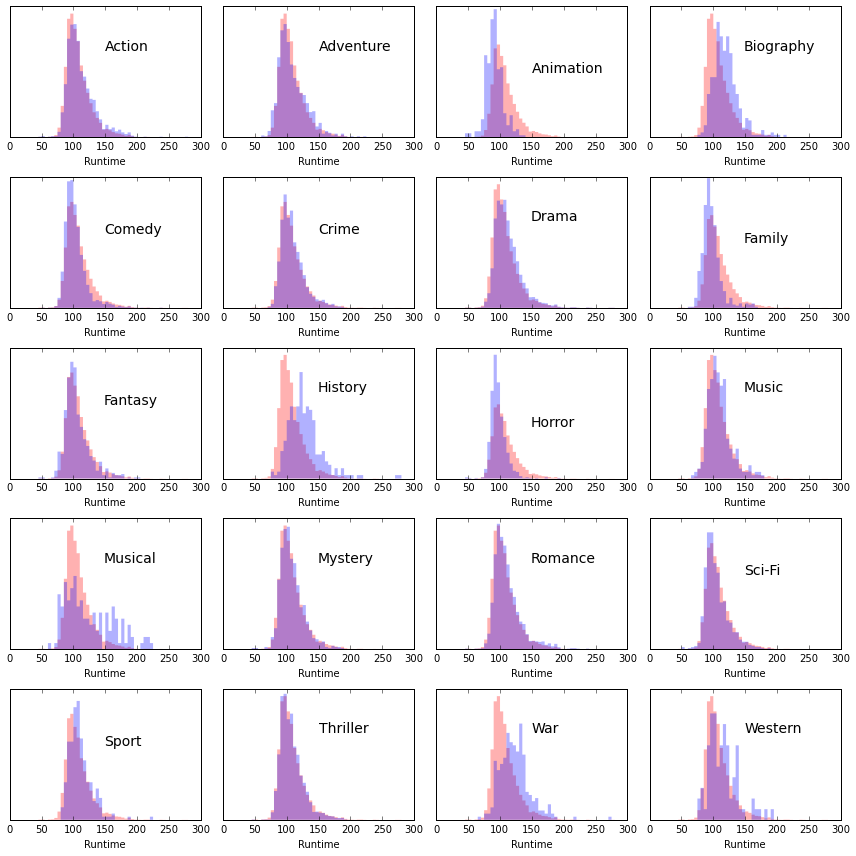

In [356]:
#We'll now make histograms that count the various runtimes
#Start by making a bunch of subplots (one for each genre)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12,12), tight_layout=True)
#Now we've made a figure with a bunch of elements (axes) in it.

bins = np.arange(0,300,5) #set the binsize to 5, and get all the corresponding bins.

# zip(list1,list2) creates a list of tuples tuple with [(list1[0],list2[0]), ... ]
# The function "ravel" is like Mathematica's "Flatten"
for ax, genre in zip(axes.ravel(), allgenres):
    # In each plot site "ax", make a histogram where we add to bins if a given film is in the genre "genre"
    ax.hist(data[data[genre]==1].Runtime.values, bins=bins, histtype="stepfilled", normed=True, color="b", alpha=0.3,ec="none")
    # In each plot site "ax", also make a histogram with ALL films
    ax.hist(data.Runtime.values, bins=bins, histtype="stepfilled", normed=True, ec="none", zorder=0, color="r", alpha=0.3)
    
    ax.annotate(genre, xy=(150, 0.02), fontsize=14)
    #ax.xaxis.set_ticks(np.arange(1990,2015,8))
    ax.set_yticks([])
    ax.set_xlabel("Runtime")

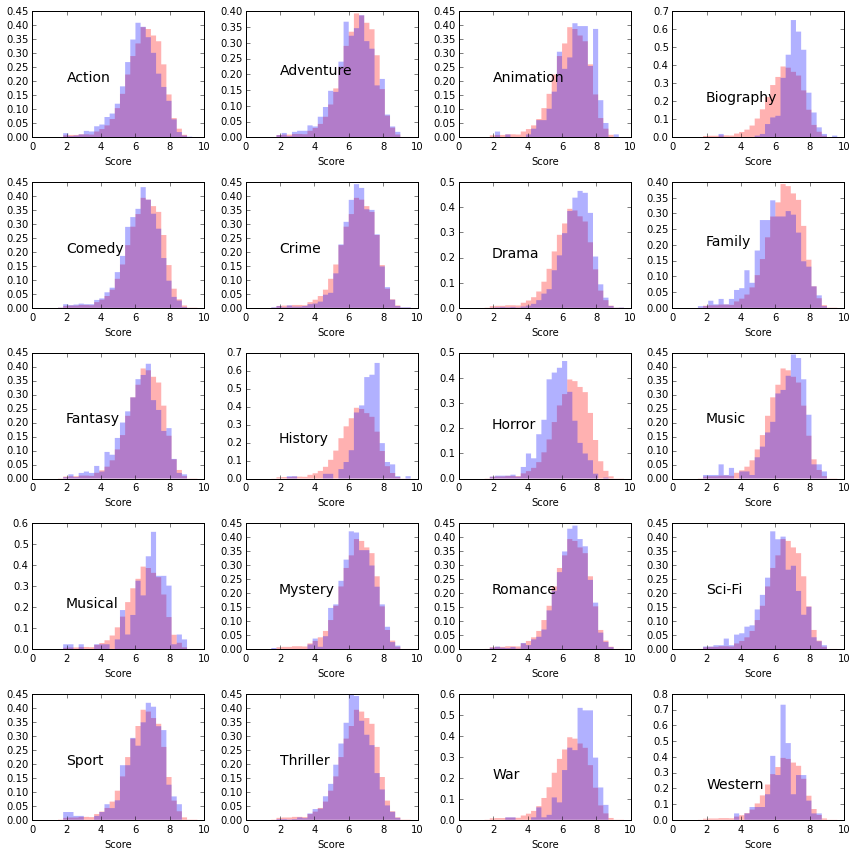

In [364]:
#We'll now make histograms that count the various runtimes
#Start by making a bunch of subplots (one for each genre)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12,12), tight_layout=True)
#Now we've made a figure with a bunch of elements (axes) in it.

bins = np.arange(0,10,0.3) #set the binsize to 5, and get all the corresponding bins.

# zip(list1,list2) creates a list of tuples tuple with [(list1[0],list2[0]), ... ]
# The function "ravel" is like Mathematica's "Flatten"
for ax, genre in zip(axes.ravel(), allgenres):
    # In each plot site "ax", make a histogram where we add to bins if a given film is in the genre "genre"
    ax.hist(data[data[genre]==1].Score.values, bins=bins, histtype="stepfilled", normed=True, color="b", alpha=0.3,ec="none")
    # In each plot site "ax", also make a histogram with ALL films
    ax.hist(data.Score.values, bins=bins, histtype="stepfilled", normed=True, ec="none", zorder=0, color="r", alpha=0.3)
    
    ax.annotate(genre, xy=(2, 0.2), fontsize=14)
    #ax.xaxis.set_ticks(np.arange(1990,2015,8))
    #ax.set_yticks([])
    ax.set_xlabel("Score")